In [1]:
import gc
import joblib
import numpy as np
import pandas as pd
import pickle
import enum

from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from scipy.sparse import coo_matrix, dok_matrix, lil_matrix, csr_matrix, bsr_matrix
from tqdm import tqdm
import lightgbm as lgb
from collections import deque
import json
from pylab import rcParams
from sklearn.metrics import roc_auc_score
from scipy import sparse
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
f_cols=[
    #basic
    'cu',#count of question of this user
    'is_first',
    #timestamp
    'ts',
    'ts_mod_day',
    'ts_mod_week',
    'ts_day',
    #question
    'question_id',
#     'task_container_id',
    'container_ord', #organ in the container
    'part',
    'bundle_id',
    'tgg',#tag group
    'qtag0',
    'tag_num',#number of tags
    'qp', #appear probability
    'qc_r',#correct rate
    #question user cum
    #Calc cumsum for question numbers
#     cum_sum',
    'cum_csum',
    'cum_crate',
    'sum_avgt',#average cosume time
    'a_ans',#already answerewd: 0 no 1 incorrect 2 correct
    #prior answer
    'pq',
    'ptag0',
    'ppart',
    'pbundle',
    'ptgg',
    'pq_correct',#whether prior answered correct
    'pqet',#remember to divide task_container num
    'pqhe',
    'tsli', #prior to current
    'tsli2',
    'tsli3',
    'clipped_tsli',#20 minutes clipped
    #for the last 5 questions
    'roll_num',
    'roll_1',
    'roll_2',
    'roll_3',
    'roll_4',
    'roll_5',
    'roll_6',
    'roll_7',
    'roll_8',
    'roll_9',
    'roll_10',
    #taggroup
    'tgp',
    'tgcr',
    'tgg_num',#user question number under this taggroup
    'tgg_cnum',#user correct question number under this taggroup
    #lecture
    'l_num',#lecture sum
    'l_tag_num',#l_num in the tag
    'l1_num',#l_num in concept
    'l2_num',#l_num in solve questions
    'l_part_num',
    #diagnostic
    'is_d',
    #part
    'pp_num',#paid part ratio 1,3,4,6,7
    'lp_num',#listening part ratio 1,2,3,4
    'pp_ratio',#paid part ratio 1,3,4,6,7
    'lp_ratio',#listening part ratio 1,2,3,4
    #answer
    'answered_correctly',
    'user_answer'
]


In [3]:

# for i in tqdm(range(900)):
#     file_x=f'train_pre/train_pre_x{i}.pkl'
#     file_y=f'train_pre/train_pre_y{i}.pkl'
#     if i==0:
#         data_x=sparse.coo_matrix(pd.read_pickle(file_x))
#         data_y=data_y+pd.read_pickle(file_y)
#     else:
#         x=sparse.coo_matrix(pd.read_pickle(file_x))
#         data_x=sparse.vstack([data_x,x])
#         data_y=data_y+pd.read_pickle(file_y)

In [4]:
k=3

In [5]:
# for i in tqdm(range(k)):
#     file_x=f'train_pre/train_pre_x{i}.pkl'
#     datas=pd.read_pickle(file_x)
#     if i==0:
#         data_x=datas
#     else:
#         data_x=[*data_x, *datas]

In [5]:
for i in tqdm(range(k)):
    file_x=f'train_pre/train_pre_x{i}.pkl'
    datas=pd.DataFrame(pd.read_pickle(file_x))
    if i==0:
        data_x=datas
    else:
        data_x=pd.concat([data_x,datas])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


In [6]:
data_x.to_csv('train_pre2.csv')

In [7]:
# data_x=[]
# for i in tqdm(range(k)):
#     file_x=f'train_pre/train_pre_x{i}.pkl'
#     datas=pd.read_pickle(file_x)
#     for data in datas:
#         data_x.append(np.array(data))

In [8]:
# %%time
# n=0
# flag=0
# for i in tqdm(range(k)):
#     file_x=f'train_pre/train_pre_x{i}.pkl'
#     datas=pd.read_pickle(file_x)
#     if flag==0:
#         data_x=datas
#         flag=1
#     else:
#         data_x=[*data_x, *datas]
#     if i%100==0:
#         file=f'train_pre_2/train_pre_x{n}.pkl'
#         with open(file, 'wb') as f:
#             pickle.dump(data_x, f, protocol=pickle.HIGHEST_PROTOCOL)
#         flag=0
#         n=n+1


In [9]:
# %%time
# data_x=np.array(data_x)

In [10]:
# # input_path=Path('C:\')
# file='train_prex.npy'
# np.save(file, data_x)

In [11]:
# import numpy as np
# file='train_prex.npy'
# np.load(file).shape

In [7]:

for i in tqdm(range(k)):
    file_y=f'train_pre/train_pre_y{i}.pkl'
    if i==0:
        data_y=pd.read_pickle(file_y)
    else:
        data_y=data_y+pd.read_pickle(file_y)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 122.84it/s]


In [10]:
pd.DataFrame(data_y).to_csv('train_y.csv')

In [13]:
# file=f'train_pre_2/train_prey.pkl'
# with open(file, 'wb') as f:
#     pickle.dump(data_y, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# data_x=[*data_x, *data_x, *data_x, *data_x, *data_x,*data_x, *data_x, *data_x, *data_x, *data_x]
# data_y=[*data_y, *data_y, *data_y, *data_y, *data_y,*data_y, *data_y, *data_y, *data_y, *data_y]

In [15]:
n=len(data_y)

In [16]:
# data_y=np.array(data_y)

In [17]:
# assert data_y.shape[0]==data_x.shape[0]

In [18]:
# import random

# r_list =[i for i in range(len(data_y))]
# random.shuffle(r_list)
# cut_point=int(len(data_y)*0.7)
# train_index=r_list[:cut_point]
# test_index=r_list[cut_point:]

In [19]:
# %%time
# X_train=data_x[train_index]
# Y_train=data_y[train_index]
# X_test=data_x[test_index]
# Y_test=data_y[test_index]

In [20]:
%%time
# X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
cut_point=int(n*0.9)
X_train=data_x[0:cut_point]
Y_train=data_y[0:cut_point]
X_test=data_x[cut_point:]
Y_test=data_y[cut_point:]

CPU times: total: 109 ms
Wall time: 135 ms


In [21]:
dtrain = lgb.Dataset(X_train, Y_train, feature_name=f_cols)
dvalid = lgb.Dataset(X_test, Y_test, feature_name=f_cols)  

In [22]:
%%time
params = {
        'objective': 'binary',
        'lambda_l1': 9.5, 
        'lambda_l2': 0.005, 
        'num_leaves': 256, 
        'feature_fraction': 0.8, 
        'bagging_fraction': 0.9, 
        'bagging_freq': 6,
        'min_child_samples': 20
        #,'device':'gpu'
    }
# callbacks=[lgb.]
lgb_model = lgb.train(params,
                    #{'objective': 'binary'}, 
                    dtrain,
                    valid_sets=[dtrain, dvalid],
                    num_boost_round=10000
                    ,callbacks=[lgb.early_stopping(100),lgb.log_evaluation(100)]
                    #,categorical_feature = ['content_id','part']
                )


[LightGBM] [Info] Number of positive: 35264969, number of negative: 18358657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.767479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7314
[LightGBM] [Info] Number of data points in the train set: 53623626, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657639 -> initscore=0.652789
[LightGBM] [Info] Start training from score 0.652789
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.525571	valid_1's binary_logloss: 0.527472
[200]	training's binary_logloss: 0.521701	valid_1's binary_logloss: 0.524095
[300]	training's binary_logloss: 0.519812	valid_1's binary_logloss: 0.522623
[400]	training's binary_logloss: 0.518641	valid_1's binary_logloss: 0.521863
[500]	training's binary_logloss: 0.517738	valid_1's binary_log

In [23]:
# clf = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#                importance_type='split', learning_rate=0.1, max_depth=-1,
#                min_child_samples=10, min_split_gain=0.0, n_estimators=200, n_jobs=-1, objective="binary",
#                random_state=42, reg_alpha = 0.2, reg_lambda = 0.6, 
#                          subsample=1.0, num_leaves = 300, min_child_weight = 0.03)
# clf.fit(X_train, Y_train)
# pred = clf.predict(X_test)
# accuracy_score(pred, Y_test)

In [24]:
lgb_result = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
print('auc:', roc_auc_score(Y_test,lgb_result))
# f_imp=dict(zip(f_cols,lgb_model.feature_importance().tolist()))
# sorted(f_imp.items(),key=(lambda x: x[1]),reverse=True)


auc: 0.7865280052314291


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

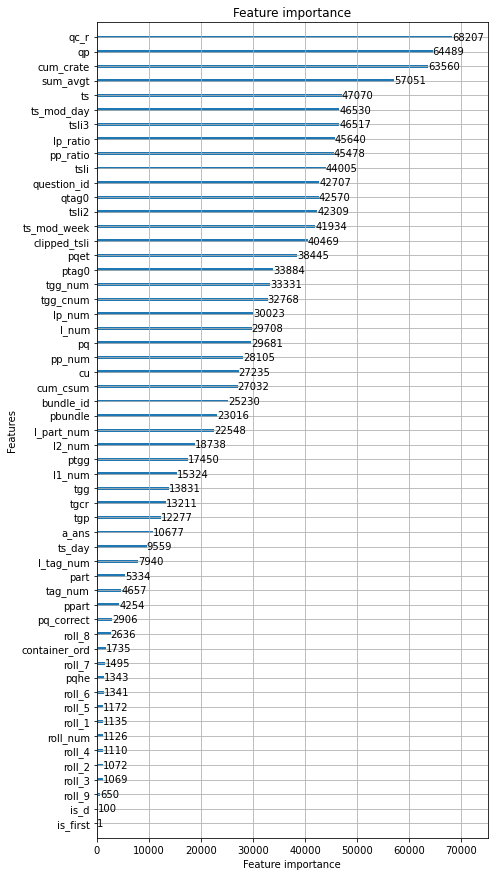

In [25]:
rcParams['figure.figsize'] = 7, 15
lgb.plot_importance(lgb_model)

In [26]:
k=10
for i in tqdm(range(k)):
    file_x=f'train_pre/train_pre_x{i+600}.pkl'
    datas=pd.read_pickle(file_x)
    if i==0:
        val_x=datas
    else:
        val_x=[*val_x, *datas]

for i in tqdm(range(k)):
    file_y=f'train_pre/train_pre_y{i+600}.pkl'
    if i==0:
        val_y=pd.read_pickle(file_y)
    else:
        val_y=val_y+pd.read_pickle(file_y)
val_x=np.array(val_x)
val_y=np.array(val_y)
# X, X_val, Y, Y_val = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
lgb_val = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
print('auc:', roc_auc_score(val_y,lgb_val))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 88.66it/s]


auc: 0.7868364829696995
